In [1]:
import rebound
import reboundx
from reboundx import constants
import numpy as np
from sys import argv
import matplotlib.pyplot as plt
%matplotlib inline

twopi = 2.*np.pi
# tmax = twopi * float(argv[1]) # Maximum integration time.
# n = int(argv[2]) # Simulation number.
tmax = twopi * 10000
juliancentury = 628.33195 # in yr/2pi
arcsec = 4.8481368e-06 # in rad
# pomega/deltat*juliancentury/arcsec

## Baseline test. Check without GR.

In [2]:
n = 0
filename = 'archives/gr_{0}.bin'.format(n)

try:
    sim = rebound.Simulation('mercury.bin')
except:
    sim = rebound.Simulation()
    sim.add(['sun', 'mercury'], date='2000-01-01 12:00')
    sim.save('mercury.bin')

sim.move_to_com()
sim.integrator = 'whckl'
sim.dt = np.sqrt(37)*twopi/365.25 # Timestep of about 6 days.
sim.ri_whfast.safe_mode = 0
sim.ri_whfast.keep_unsynchronized = True
sim.exit_min_distance = 3e-3 # Distance between the Earth and Moon.
sim.exit_max_distance = 1000. # Unlikely that the planet is bound.
sim.automateSimulationArchive(filename, step=int(0.1*twopi/sim.dt), deletefile=True) # save snapshots every 10 years

In [3]:
print('Start integrating.')
try:
    sim.integrate(tmax, exact_finish_time=False)
except rebound.Escape as esc:
    print(esc)
except rebound.Encounter as enc:
    print(enc)
print('Finished integrating.')

Start integrating.
Finished integrating.


In [4]:
sa = rebound.SimulationArchive(filename)
N = sa.nblobs
t = np.zeros(N)
pomega = np.zeros(N)
for i in range(N):
    s = sa[i]
    s.integrator_synchronize()
    t[i] = s.t/twopi
    pomega[i] = s.particles[1].pomega

/Users/zyrxvo/Library/Mobile Documents/com~apple~CloudDocs/Documents/Research/packages/rebound/rebound/simulationarchive.py:148: RuntimeWarning: The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().
  warnings.warn("The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().", RuntimeWarning)


In [5]:
(pomega[-1]-pomega[0])/tmax*juliancentury/arcsec

-4.4518538649578714e-10

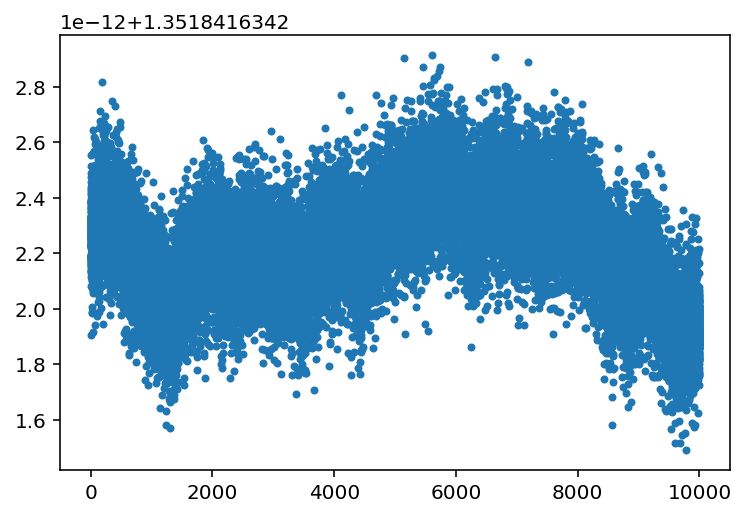

In [6]:
plt.plot(t, pomega, '.')
plt.show()

## Baseline test. Check the standard amount of GR Precession

In [7]:
n = 1
filename = 'archives/gr_{0}.bin'.format(n)

try:
    sim = rebound.Simulation('mercury.bin')
except:
    sim = rebound.Simulation()
    sim.add(['sun', 'mercury'], date='2000-01-01 12:00')
    sim.save('mercury.bin')

sim.move_to_com()
sim.integrator = 'whckl'
sim.dt = np.sqrt(37)*twopi/365.25 # Timestep of about 6 days.
sim.ri_whfast.safe_mode = 0
sim.ri_whfast.keep_unsynchronized = True
sim.exit_min_distance = 3e-3 # Distance between the Earth and Moon.
sim.exit_max_distance = 1000. # Unlikely that the planet is bound.
sim.automateSimulationArchive(filename, step=int(0.1*twopi/sim.dt), deletefile=True) # save snapshots every 10 years

rebx = reboundx.Extras(sim)
gr = rebx.load_force('gr_potential')
rebx.add_force(gr)
gr.params['c'] = constants.C

In [8]:
print('Start integrating.')
try:
    sim.integrate(tmax, exact_finish_time=False)
except rebound.Escape as esc:
    print(esc)
except rebound.Encounter as enc:
    print(enc)
print('Finished integrating.')

Start integrating.
Finished integrating.


In [9]:
sa = rebound.SimulationArchive(filename)
N = sa.nblobs
t = np.zeros(N)
pomega = np.zeros(N)
for i in range(N):
    s = sa[i]
    s.integrator_synchronize()
    t[i] = s.t/twopi
    pomega[i] = s.particles[1].pomega

/Users/zyrxvo/Library/Mobile Documents/com~apple~CloudDocs/Documents/Research/packages/rebound/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/zyrxvo/Library/Mobile Documents/com~apple~CloudDocs/Documents/Research/packages/rebound/rebound/simulationarchive.py:148: RuntimeWarning: The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().
  warnings.warn("The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().", RuntimeWarning)


In [10]:
(pomega[-1]-pomega[0])/tmax*juliancentury/arcsec

42.98181349103076

As expected there was pericenter precession. The literature value is 42.98 arcsec / century.   

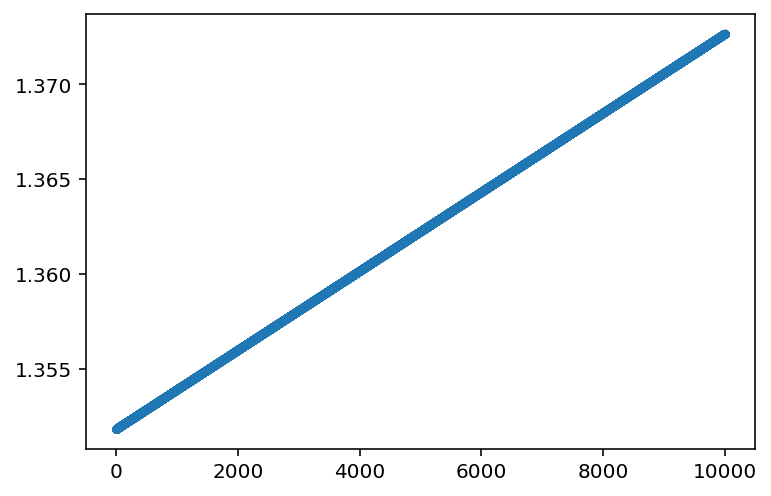

In [11]:
plt.plot(t, pomega, '.')
plt.show()

## Check the precession from GR as the speed of light changes.

In [12]:
n = 2
filename = 'archives/gr_{0}.bin'.format(n)

try:
    sim = rebound.Simulation('mercury.bin')
except:
    sim = rebound.Simulation()
    sim.add(['sun', 'mercury'], date='2000-01-01 12:00')
    sim.save('mercury.bin')

sim.move_to_com()
sim.integrator = 'whckl'
sim.dt = np.sqrt(37)*twopi/365.25 # Timestep of about 6 days.
sim.ri_whfast.safe_mode = 0
sim.ri_whfast.keep_unsynchronized = True
sim.exit_min_distance = 3e-3 # Distance between the Earth and Moon.
sim.exit_max_distance = 1000. # Unlikely that the planet is bound.
sim.automateSimulationArchive(filename, step=int(0.1*twopi/sim.dt), deletefile=True) # save snapshots every 10 years

rebx = reboundx.Extras(sim)
gr = rebx.load_force('gr_potential')
rebx.add_force(gr)
gr.params['c'] = constants.C

def a(t,t0):
    if t < 0: t = 0
    if t > t0: t = t0
    return 1 - (1 - 1e-4) * t/t0

def heartbeat(s):
    gr.params['c'] = constants.C / np.sqrt(a(s.contents.t, tmax))

sim.heartbeat = heartbeat

In [13]:
print('Start integrating.')
try:
    sim.integrate(tmax, exact_finish_time=False)
except rebound.Escape as esc:
    print(esc)
except rebound.Encounter as enc:
    print(enc)
print('Finished integrating.')

Start integrating.
Finished integrating.


In [14]:
sa = rebound.SimulationArchive(filename)
N = sa.nblobs
t = np.zeros(N)
pomega = np.zeros(N)
for i in range(N):
    s = sa[i]
    s.integrator_synchronize()
    t[i] = s.t/twopi
    pomega[i] = s.particles[1].pomega

/Users/zyrxvo/Library/Mobile Documents/com~apple~CloudDocs/Documents/Research/packages/rebound/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/zyrxvo/Library/Mobile Documents/com~apple~CloudDocs/Documents/Research/packages/rebound/rebound/simulationarchive.py:148: RuntimeWarning: The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().
  warnings.warn("The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().", RuntimeWarning)


In [15]:
(pomega[-1]-pomega[0])/tmax*juliancentury/arcsec

21.49329467907248

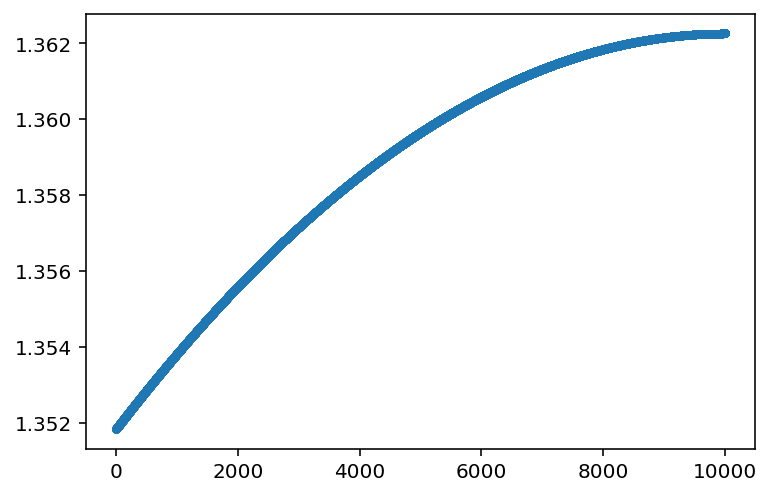

In [16]:
plt.plot(t, pomega, '.')
plt.show()

## Check the precession from GR as the speed of light changes.

In [18]:
n = 3
filename = 'archives/gr_{0}.bin'.format(n)

try:
    sim = rebound.Simulation('mercury.bin')
except:
    sim = rebound.Simulation()
    sim.add(['sun', 'mercury'], date='2000-01-01 12:00')
    sim.save('mercury.bin')

sim.move_to_com()
sim.integrator = 'whckl'
sim.dt = np.sqrt(37)*twopi/365.25 # Timestep of about 6 days.
sim.ri_whfast.safe_mode = 0
sim.ri_whfast.keep_unsynchronized = True
sim.exit_min_distance = 3e-3 # Distance between the Earth and Moon.
sim.exit_max_distance = 1000. # Unlikely that the planet is bound.
sim.automateSimulationArchive(filename, step=int(0.1*twopi/sim.dt), deletefile=True) # save snapshots every 10 years

rebx = reboundx.Extras(sim)
gr = rebx.load_force('gr_potential')
rebx.add_force(gr)
gr.params['c'] = constants.C

def a(t,t0):
    if t < 0: t = 0
    if t > t0: t = t0
    return 1 - (1 - 1e4) * t/t0

def heartbeat(s):
    gr.params['c'] = constants.C / np.sqrt(a(s.contents.t, tmax))

sim.heartbeat = heartbeat

In [19]:
print('Start integrating.')
try:
    sim.integrate(tmax, exact_finish_time=False)
except rebound.Escape as esc:
    print(esc)
except rebound.Encounter as enc:
    print(enc)
print('Finished integrating.')

Start integrating.
Finished integrating.


In [20]:
sa = rebound.SimulationArchive(filename)
N = sa.nblobs
t = np.zeros(N)
pomega = np.zeros(N)
for i in range(N):
    s = sa[i]
    s.integrator_synchronize()
    t[i] = s.t/twopi
    pomega[i] = s.particles[1].pomega

/Users/zyrxvo/Library/Mobile Documents/com~apple~CloudDocs/Documents/Research/packages/rebound/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/zyrxvo/Library/Mobile Documents/com~apple~CloudDocs/Documents/Research/packages/rebound/rebound/simulationarchive.py:148: RuntimeWarning: The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().
  warnings.warn("The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().", RuntimeWarning)


In [21]:
(pomega[-1]-pomega[0])/tmax*juliancentury/arcsec

-4873.615126990716

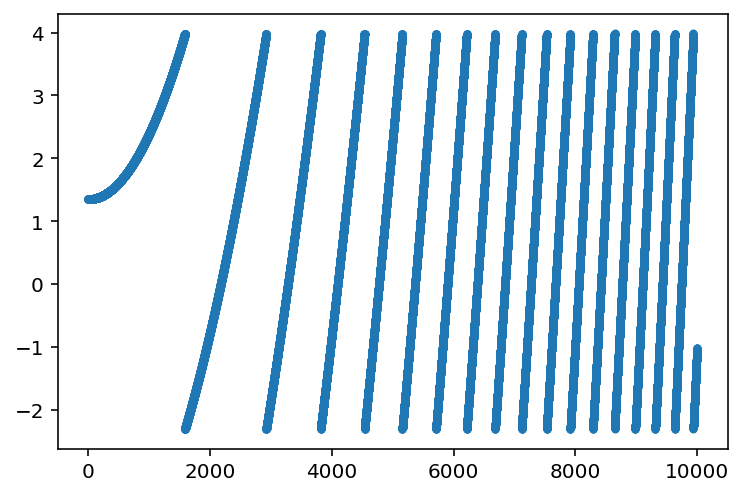

In [22]:
plt.plot(t, pomega, '.')
plt.show()

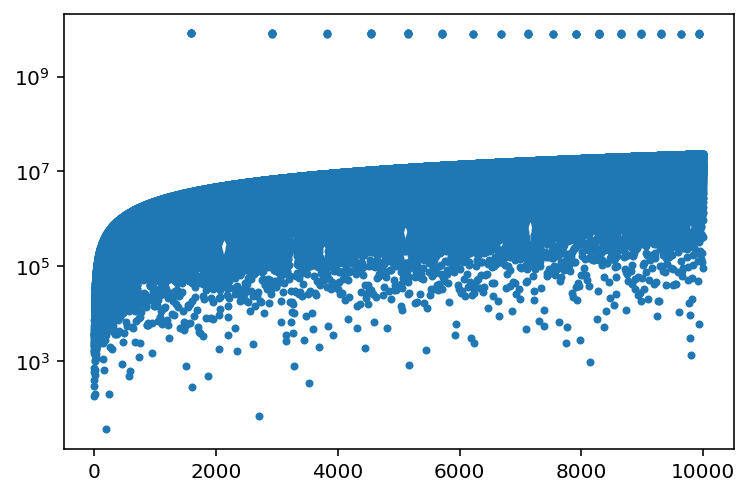

In [25]:
plt.plot(t[:-1], np.abs((pomega[1:]-pomega[:-1])/(t[1:]-t[:-1])*juliancentury/arcsec), '.')
plt.yscale('log')
plt.show()

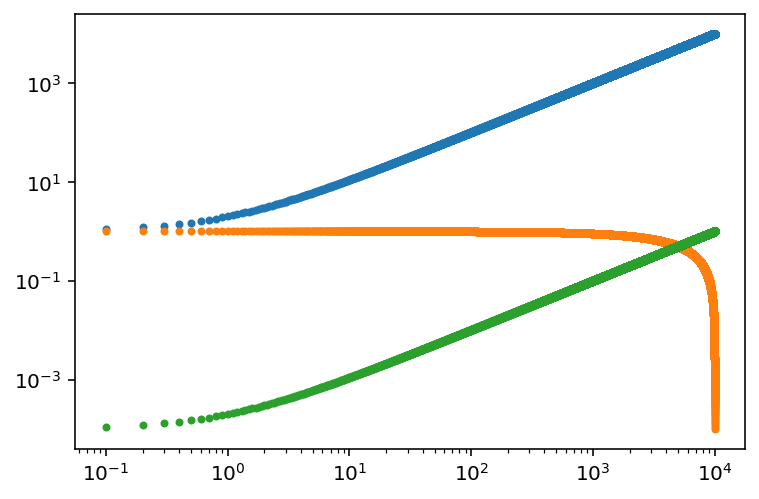

In [31]:
plt.plot(t, 1 - (1 - 1e4)*(t/t[-1]), '.')
plt.plot(t, 1 - (1 - 1e-4)*(t/t[-1]), '.')
plt.plot(t, 1e-4 + (1 - 1e-4)*(t/t[-1]), '.')
plt.xscale('log')
plt.yscale('log')
plt.show()

## Check the amount of GR Precession using the Hacked REBOUNDx

In [1]:
import rebound
import reboundx
from reboundx import constants
import numpy as np
from sys import argv
import matplotlib.pyplot as plt
%matplotlib inline

twopi = 2.*np.pi
# tmax = twopi * float(argv[1]) # Maximum integration time.
# n = int(argv[2]) # Simulation number.
tmax = twopi * 10000
juliancentury = 628.33195 # in yr/2pi
arcsec = 4.8481368e-06 # in rad
# pomega/deltat*juliancentury/arcsec

### With a "positive" TMAX

In [2]:
n = 6
filename = 'archives/gr_{0}.bin'.format(n)

try:
    sim = rebound.Simulation('mercury.bin')
except:
    sim = rebound.Simulation()
    sim.add(['sun', 'mercury'], date='2000-01-01 12:00')
    sim.save('mercury.bin')

sim.move_to_com()
sim.integrator = 'whckl'
sim.dt = np.sqrt(37)*twopi/365.25 # Timestep of about 6 days.
sim.ri_whfast.safe_mode = 0
sim.ri_whfast.keep_unsynchronized = True
sim.exit_min_distance = 3e-3 # Distance between the Earth and Moon.
sim.exit_max_distance = 1000. # Unlikely that the planet is bound.
sim.automateSimulationArchive(filename, step=int(0.1*twopi/sim.dt), deletefile=True) # save snapshots every 10 years

rebx = reboundx.Extras(sim)
gr = rebx.load_force('gr_potential')
rebx.add_force(gr)
gr.params['c'] = tmax

In [3]:
print('Start integrating.')
try:
    sim.integrate(tmax, exact_finish_time=False)
except rebound.Escape as esc:
    print(esc)
except rebound.Encounter as enc:
    print(enc)
print('Finished integrating.')

Start integrating.
Finished integrating.


In [4]:
sa = rebound.SimulationArchive(filename)
N = sa.nblobs
t = np.zeros(N)
pomega = np.zeros(N)
for i in range(N):
    s = sa[i]
    s.integrator_synchronize()
    t[i] = s.t/twopi
    pomega[i] = s.particles[1].pomega

/Users/zyrxvo/Library/Mobile Documents/com~apple~CloudDocs/Documents/Research/packages/rebound/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/zyrxvo/Library/Mobile Documents/com~apple~CloudDocs/Documents/Research/packages/rebound/rebound/simulationarchive.py:148: RuntimeWarning: The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().
  warnings.warn("The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().", RuntimeWarning)


In [5]:
(pomega[-1]-pomega[0])/tmax*juliancentury/arcsec

-4873.259333642155

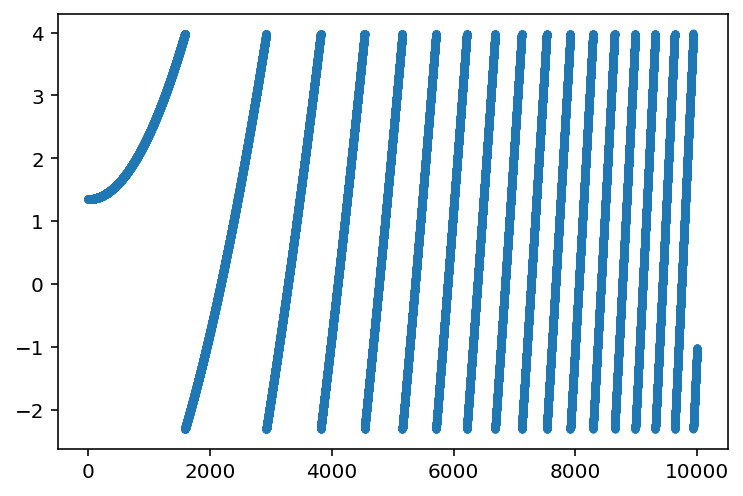

In [6]:
plt.plot(t, pomega, '.')
plt.show()

### With a "negative" TMAX

In [7]:
n = 7
filename = 'archives/gr_{0}.bin'.format(n)

try:
    sim = rebound.Simulation('mercury.bin')
except:
    sim = rebound.Simulation()
    sim.add(['sun', 'mercury'], date='2000-01-01 12:00')
    sim.save('mercury.bin')

sim.move_to_com()
sim.integrator = 'whckl'
sim.dt = np.sqrt(37)*twopi/365.25 # Timestep of about 6 days.
sim.ri_whfast.safe_mode = 0
sim.ri_whfast.keep_unsynchronized = True
sim.exit_min_distance = 3e-3 # Distance between the Earth and Moon.
sim.exit_max_distance = 1000. # Unlikely that the planet is bound.
sim.automateSimulationArchive(filename, step=int(0.1*twopi/sim.dt), deletefile=True) # save snapshots every 10 years

rebx = reboundx.Extras(sim)
gr = rebx.load_force('gr_potential')
rebx.add_force(gr)
gr.params['c'] = -tmax

In [8]:
print('Start integrating.')
try:
    sim.integrate(tmax, exact_finish_time=False)
except rebound.Escape as esc:
    print(esc)
except rebound.Encounter as enc:
    print(enc)
print('Finished integrating.')

Start integrating.
Finished integrating.


In [9]:
sa = rebound.SimulationArchive(filename)
N = sa.nblobs
t = np.zeros(N)
pomega = np.zeros(N)
for i in range(N):
    s = sa[i]
    s.integrator_synchronize()
    t[i] = s.t/twopi
    pomega[i] = s.particles[1].pomega

/Users/zyrxvo/Library/Mobile Documents/com~apple~CloudDocs/Documents/Research/packages/rebound/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/zyrxvo/Library/Mobile Documents/com~apple~CloudDocs/Documents/Research/packages/rebound/rebound/simulationarchive.py:148: RuntimeWarning: The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().
  warnings.warn("The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().", RuntimeWarning)


In [10]:
(pomega[-1]-pomega[0])/tmax*juliancentury/arcsec

21.49325889268763

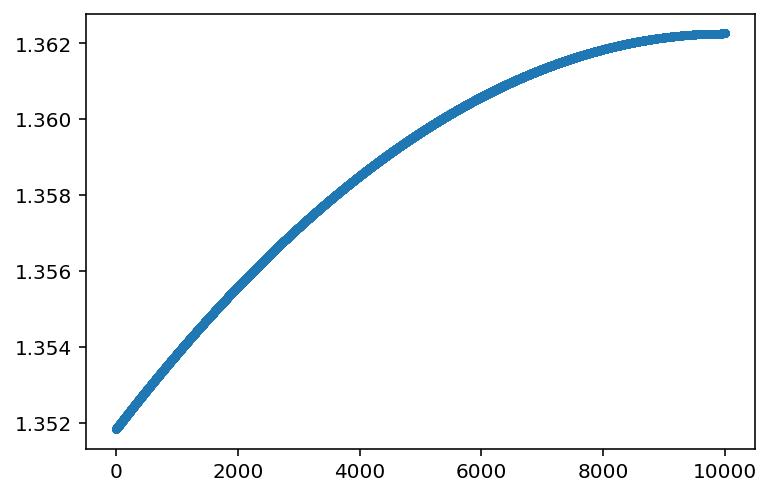

In [11]:
plt.plot(t, pomega, '.')
plt.show()